In [15]:
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler, Sampler, SubsetRandomSampler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy

import albumentations as A
from albumentations.pytorch import ToTensorV2

from math import ceil
import seaborn as sn

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{bcolors.OK}{device}{bcolors.RESET}')

cuda:0


In [19]:
# set the attempt number in attempt
# # set the model name in model
# set the model version in version

hyper_parameter = {
    "attempt": 0.8,
    "model": 'efficientnet',
    "version": 'b0',
    "learning_rate": 0.1,
    "batch_size": 32,
    "num_workers": 2,
    "no_epochs": 50,
    "image_size": 224, 
    "in_channels": 3, 
    "num_classes": 8,
    "load_model": True
}

In [20]:
# set data directory
data_dir = 'D:\sl\images'
sets = ['train', 'test']
# to use checkpoint saving create a directory named "checkpoint" and a sub directory in the name of the model
checkpoint_path = f'./checkpoints/{hyper_parameter["model"]}/{hyper_parameter["model"]}{hyper_parameter["version"]}-{hyper_parameter["attempt"]}'


print(f'{bcolors.OK}Enviroment setup complete 😊🐼!{bcolors.RESET}')

Enviroment setup complete 😊🐼!


In [21]:
classes = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
image_frequency = pd.DataFrame(columns=sets, index=classes)
for dataset in iter(sets):
    for classname in iter(classes):
        image_frequency[dataset][classname] = len(os.listdir(os.path.join(data_dir, dataset, classname)))
image_frequency.index = image_frequency.index.rename('classes')

print(image_frequency.to_markdown())
print(image_frequency.sum(axis=0))

| classes   |   train |   test |
|:----------|--------:|-------:|
| AK        |     689 |    178 |
| BCC       |    2669 |    654 |
| BKL       |    2077 |    547 |
| DF        |     180 |     59 |
| MEL       |    3608 |    914 |
| NV        |   10330 |   2545 |
| SCC       |     509 |    119 |
| VASC      |     203 |     50 |
train    20265
test      5066
dtype: object


In [22]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [23]:
# set the mean and std based on the model documentation
# for efficient net bo - pytorch documentation
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# hyper_parameter['image_size']=32

data_transforms = {
    'train': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()]),
    'test': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()])
}

In [24]:
# create dataset and dataloader
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =Transforms(transforms=data_transforms[x])) for x in sets}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=hyper_parameter['batch_size'], shuffle=True) for x in sets}

dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes

print('train: {} test: {}'.format(dataset_sizes['train'], dataset_sizes['test']))
print(class_names)

train: 20265 test: 5066
['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [25]:
# Train Loader - count the frequency of images in every iteration
num_ak, num_bcc, num_bkl, num_df, num_mel, num_nv, num_scc, num_vasc = 0,0,0,0,0,0,0,0
for data, labels in dataloaders['train']:
    num_ak += torch.sum(labels==0)
    num_bcc += torch.sum(labels==1)
    num_bkl += torch.sum(labels==2)
    num_df += torch.sum(labels==3)
    num_mel += torch.sum(labels==4)
    num_nv += torch.sum(labels==5)
    num_scc += torch.sum(labels==6)
    num_vasc += torch.sum(labels==7)
print(f'AK: {num_ak}, BCC: {num_bcc}, BKL: {num_bkl}, DF: {num_df}, MEL: {num_mel}, NV: {num_nv}, SCC: {num_scc}, VASC: {num_vasc}')

AK: 689, BCC: 2669, BKL: 2077, DF: 180, MEL: 3608, NV: 10330, SCC: 509, VASC: 203


In [26]:
# Test Loader - count the frequency of images in every iteration
num_ak, num_bcc, num_bkl, num_df, num_mel, num_nv, num_scc, num_vasc = 0,0,0,0,0,0,0,0
for data, labels in dataloaders['test']:
    num_ak += torch.sum(labels==0)
    num_bcc += torch.sum(labels==1)
    num_bkl += torch.sum(labels==2)
    num_df += torch.sum(labels==3)
    num_mel += torch.sum(labels==4)
    num_nv += torch.sum(labels==5)
    num_scc += torch.sum(labels==6)
    num_vasc += torch.sum(labels==7)
print(f'AK: {num_ak}, BCC: {num_bcc}, BKL: {num_bkl}, DF: {num_df}, MEL: {num_mel}, NV: {num_nv}, SCC: {num_scc}, VASC: {num_vasc}')

AK: 178, BCC: 654, BKL: 547, DF: 59, MEL: 914, NV: 2545, SCC: 119, VASC: 50


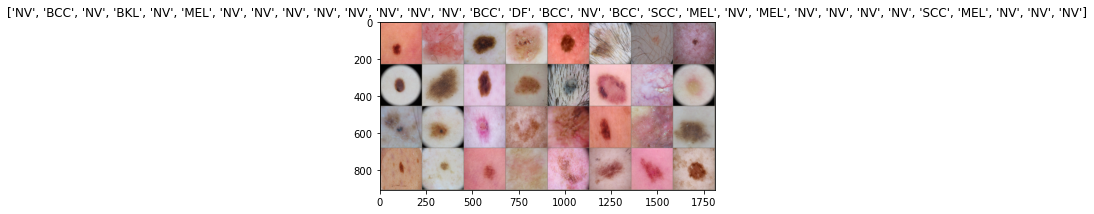

In [27]:
# Helper function for inline image display
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

images, classes = next(iter(dataloaders['train']))

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid, title=[class_names[x] for x in classes])

In [28]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)

In [29]:
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [30]:
# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
    
#     def forward(self, x):
#         return x

In [31]:
version = hyper_parameter['version']
model = EfficientNet(version=version, num_classes=hyper_parameter['num_classes'])

In [32]:
# define model and optimizers
model.to(device)

next(model.parameters()).device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = hyper_parameter['learning_rate'])

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [33]:
# view model architecture
# print(model.parameters)

In [34]:
train_results = {
    'accuracy': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'f1_score': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'loss': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'cf_matrix': np.zeros((hyper_parameter['num_classes'], hyper_parameter['num_classes']), dtype=float)
}

test_results = {
    'accuracy': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'f1_score': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'loss': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'cf_matrix': np.zeros((hyper_parameter['num_classes'], hyper_parameter['num_classes']), dtype=float)
}

results = {
    'train': train_results,
    'test': test_results
}

In [35]:
save_path = f'{checkpoint_path}.pth.tar'
print(f'Save Path: {save_path}')

def save_checkpoint(state, epoch, filename = save_path):
    print(f'=> Checkpoint at {epoch + 1} saved!')
    print(f'Saved at: {save_path}')
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    print(f'=> Loading Checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

Save Path: ./checkpoints/efficientnet/efficientnetb0-0.8.pth.tar


In [36]:
def train_model(model, cirterion, optimizer, scheduler, num_epochs = 1):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_f1_scr = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 15)

    for phase in ['train', 'test']:
      if phase =='train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      real_targets = []
      predicted_targets = []

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history only if train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          
          real_targets.extend(labels.detach().cpu().numpy())
          predicted_targets.extend(preds.detach().cpu().numpy())

          loss = cirterion(outputs, labels)

          # backward + optimize only if in train
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      ### EPOCH Train & Test ###
      if phase == 'train':
        scheduler.step()

      sk_f1 = f1_score(predicted_targets, real_targets, average='micro')
      epoch_cf_matrix = confusion_matrix(real_targets, predicted_targets)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects / dataset_sizes[phase]

      results[phase]['accuracy'][epoch] = epoch_acc
      results[phase]['loss'][epoch] = epoch_loss
      results[phase]['f1_score'][epoch] = sk_f1
      results[phase]['cf_matrix'] += epoch_cf_matrix

      # printing epoch resutlts
      if (epoch + 1) % 2 == 0:
        print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

      epoch_time = time.time() - since
      print(f'Epoch time: {epoch_time // 60:.0f}m {epoch_time %  60:.0f}s')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      
      if phase == 'test' and sk_f1 > best_f1_scr:
        best_f1_scr = sk_f1
    
    if (epoch + 1) % 2 == 0:
      checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
      }
      save_checkpoint(checkpoint, epoch)

    print()
    ######################################################

  # training Complete
  # printing time require to train model
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')

  t = time.localtime()
  current_time = time.strftime("%H:%M", t)
  print(f'Trainig completed at {current_time}')
  print(f'Best val Acc: {best_acc:4f}')
  print(f'Best sk F1 : {best_f1_scr:4f}')

  for phase in ['train', 'test']:
    df_cm = pd.DataFrame(results[phase]['cf_matrix'], index = class_names, columns = class_names)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_cf_matrix.svg')
  plt.show()

  for phase in ['train', 'test']:
    plt.plot(results[phase]['accuracy'], label='{} accuracy'.format(phase))
    plt.title(f'{hyper_parameter["model"]} {hyper_parameter["version"]} learning rate: {hyper_parameter["learning_rate"]} epoch: {hyper_parameter["no_epochs"]}')
    plt.legend(bbox_to_anchor = (1.45, 1), loc='upper right')
    plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_accuracy.svg')
  plt.show()

  # for phase in ['train', 'test']:
  #   plt.plot(results[phase]['f1_score'], label='{} f1 score'.format(phase))
  #   plt.legend(bbox_to_anchor = (1.45, 1), loc='upper right')
  #   plt.tight_layout()
  # plt.savefig(f'{checkpoint_path}_f1_score.svg')
  # plt.show()
  
  for phase in ['train', 'test']:
    plt.plot(results[phase]['loss'], label='{} loss'.format(phase))
    plt.title(f'{hyper_parameter["model"]} {hyper_parameter["version"]} learning rate: {hyper_parameter["learning_rate"]} epoch: {hyper_parameter["no_epochs"]}')
    plt.legend(bbox_to_anchor = (1.45, 1), loc='upper right')
    plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_loss.svg')
  plt.show()

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [37]:
# load_path = f'{checkpoint_path}.pth.tar'
# if hyper_parameter['load_model']:
#     load_checkpoint(torch.load(load_path))

In [38]:
# weights = dict()
# for name, para in model.named_parameters():
#     weights[name] = para
# print(weights)

Epoch 1/50
---------------
Epoch time: 18m 4s
Epoch time: 21m 27s

Epoch 2/50
---------------
train Loss: 1.6075, Acc: 0.4653
Epoch time: 38m 49s
test Loss: 1.4669, Acc: 0.5057
Epoch time: 42m 10s
=> Checkpoint at 2 saved!
Saved at: ./checkpoints/efficientnet/efficientnetb0-0.8.pth.tar

Epoch 3/50
---------------
Epoch time: 59m 25s
Epoch time: 62m 59s

Epoch 4/50
---------------
train Loss: 1.6206, Acc: 0.4808
Epoch time: 83m 23s
test Loss: 1.3017, Acc: 0.5338
Epoch time: 86m 38s
=> Checkpoint at 4 saved!
Saved at: ./checkpoints/efficientnet/efficientnetb0-0.8.pth.tar

Epoch 5/50
---------------
Epoch time: 104m 8s
Epoch time: 107m 17s

Epoch 6/50
---------------
train Loss: 1.3047, Acc: 0.5354
Epoch time: 123m 30s
test Loss: 1.2918, Acc: 0.5486
Epoch time: 127m 15s
=> Checkpoint at 6 saved!
Saved at: ./checkpoints/efficientnet/efficientnetb0-0.8.pth.tar

Epoch 7/50
---------------
Epoch time: 144m 27s
Epoch time: 147m 50s

Epoch 8/50
---------------
train Loss: 1.3763, Acc: 0.5212
Ep

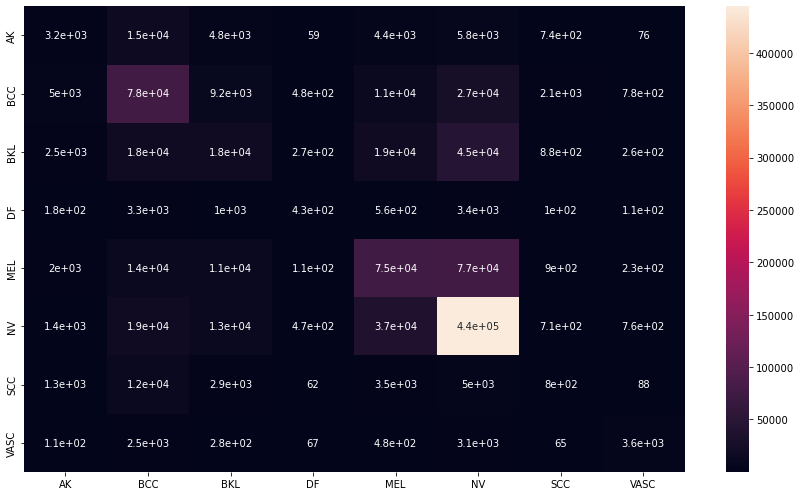

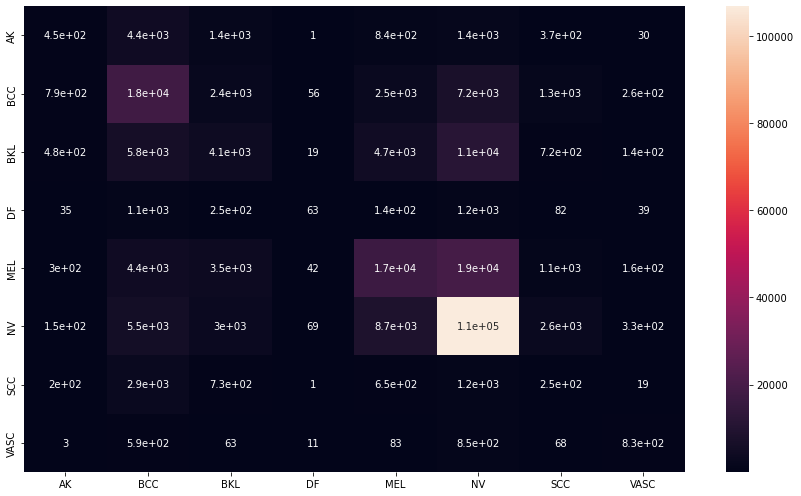

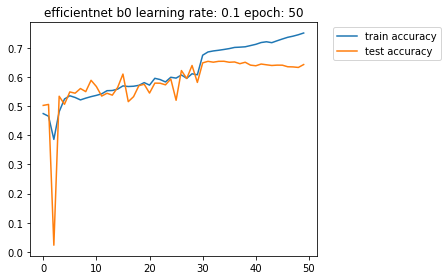

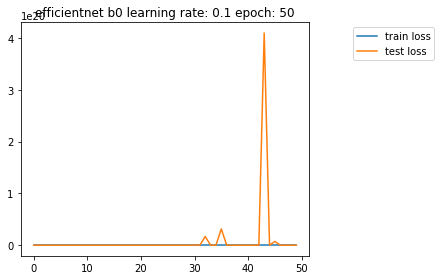

In [39]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=hyper_parameter['no_epochs'])

In [43]:
# Export to CSV
for phase in ['train', 'test']:
    for metric in ['accuracy', 'loss']:
        df = pd.DataFrame(results[phase][metric])
        df.to_csv(f'D:/sl/CSV/{hyper_parameter["model"]}-{hyper_parameter["version"]}-{phase}-{metric}-{hyper_parameter["attempt"]}.csv', mode='a')

In [44]:
for phase in ['train', 'test']:
    csv_path = f'./CSV/{hyper_parameter["model"]}-{hyper_parameter["version"]}-{phase}-{metric}-{hyper_parameter["attempt"]}.csv'
    for metric in ['accuracy', 'loss']:
        prev_result = pd.read_csv(csv_path)

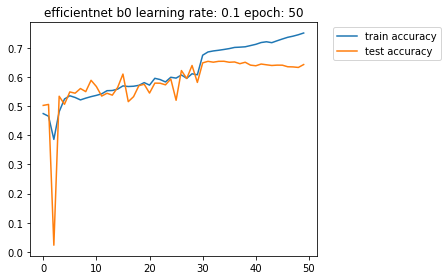

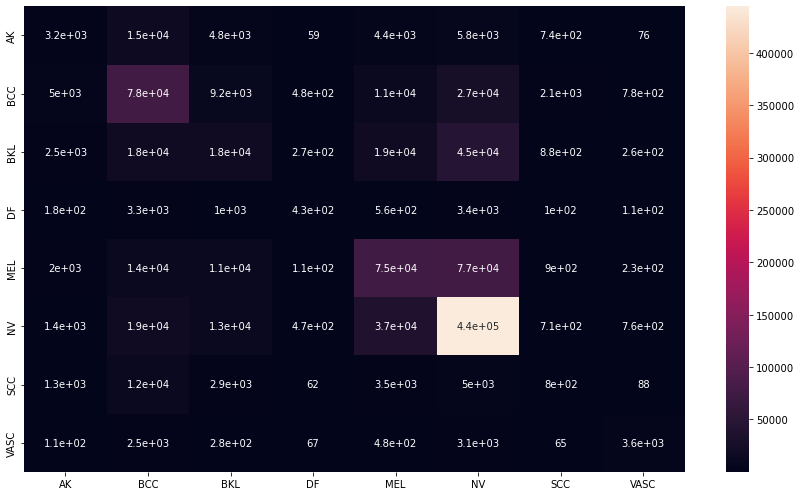

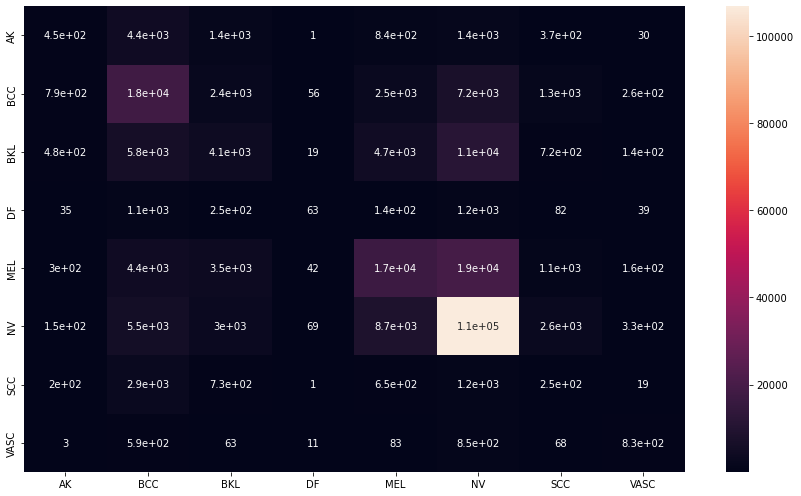

In [45]:
for phase in ['train', 'test']:
    plt.plot(results[phase]['accuracy'], label='{} accuracy'.format(phase))
    plt.title(f'{hyper_parameter["model"]} {hyper_parameter["version"]} learning rate: {hyper_parameter["learning_rate"]} epoch: {hyper_parameter["no_epochs"]}')
    plt.legend(bbox_to_anchor = (1.45, 1), loc='upper right')
    plt.tight_layout()
    plt.savefig(f'accuracy.jpeg')
plt.show()

for phase in ['train', 'test']:
    df_cm = pd.DataFrame(results[phase]['cf_matrix'], index = class_names, columns = class_names)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.tight_layout()
    plt.savefig(f'cf_matrix{phase}.jpeg')
plt.show()

# Methods to try
https://stackoverflow.com/questions/62319228/number-of-instances-per-class-in-pytorch-dataset